In [11]:
!pip install h5py=='2.9.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Understanding Data

Trainset.json contains:
*   qid
*   image_name
*   image_organ
*   answer
*   answer_type
*   question
*   question_type
*   phrase_type

An example is: {"qid": 1, "image_name": "synpic54610.jpg", "image_organ": "HEAD", "answer": "Yes", "answer_type": "CLOSED", "question_type": "PRES", "question": "Are regions of the brain infarcted?", "phrase_type": "freeform"}

VQA_RAD Image Folder contains the images in .jpg format, whose name are the qid as mentioned in the trainset.json.



In [12]:
import pandas as pd
import json

image_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder'
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))      

questions_df = pd.DataFrame(imgs_train)
questions_df.head(5)

,qid,image_name,image_organ,answer,answer_type,question_type,question,phrase_type
0,1,synpic54610.jpg,HEAD,Yes,CLOSED,PRES,Are regions of the brain infarcted?,freeform
1,2,synpic29265.jpg,CHEST,No,CLOSED,ABN,Are the lungs normal appearing?,freeform
2,3,synpic29265.jpg,CHEST,No,CLOSED,PRES,Is there evidence of a pneumothorax,freeform
3,4,synpic28602.jpg,CHEST,ultrasound,OPEN,MODALITY,What type of imaging does this not represent?,freeform
4,5,synpic29265.jpg,CHEST,no,CLOSED,MODALITY,Is this a MRI of the chest?,freeform


## Word Embeddings

A pretained model is used for word to vector conversion, [Google News Vector](https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300) for vectorizing all the questions.
It is trained on the Google News dataset on about 100 billion words.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Loading the pretained model.
model_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/GoogleNews-vectors-negative300.bin'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)                                            # Loading the model using gensim

## Extraction of features

Extracting the features  in questions.

*   Input is a sentence
*   Output is the Word Embedding of the sentence 





In [13]:
import json
import h5py
import numpy as np
import pandas as pd
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import re
import cv2
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def extract_feat(doc):
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

## Preprocessing the questions




*   Input is the question from trainset.json

*   The task is to perform tokenization and lowering of the question

*   Output is the Embedded version of the question




In [6]:
import re

def tokenize(sentence):
    #Perform Tokenization
    return [i for i in re.split(r"([-.\"',:? !$#@~()*&\^%;/\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

In [7]:
# The final result is the input list of images, where each image has a key-value pair "processed_tokens": list of tokens, added to it. 

def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

In [8]:
# Visualizing the type of answers present in the dataset

def get_top_answers(imgs, num_ans):
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]

## Preprocessing answers

atoi and itoa are Python dictionary comprehensions. They are used to create mappings between words (w) and their corresponding integer indices (i) and vice versa.


*   top_ans is a list of words, in this case, it's assumed that it contains the most frequent answers in the dataset.
 


*   atoi is defined as a dictionary comprehension that maps each word in top_ans to its corresponding index. The mapping is done by iterating over the enumerated list of words, where the index i is the key and the word w is the value.

*   itoa is also defined in a similar way but as the opposite of atoi, it maps each index to its corresponding word in top_ans.





In [17]:
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))      
num_ans = 1000

top_ans = get_top_answers(imgs_train, num_ans)    

atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
                                           
imgs_data_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))  # trainset.json
num_ans = 10                                                  # 10 represents the top 10 answers to a picture
method = 'nltk'
max_length = 21                                               # Max Length of the question
dir_path = "/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/newh5files"     # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder'

top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')


In [12]:
print(atoi)

{'no': 0, 'yes': 1, 'right': 2, 'axial': 3, 'left': 4, 'fat': 5, 'pa': 6, 'right lung': 7, 'pancreas': 8, 'one': 9, 'left kidney': 10, 'diffuse': 11, 'right upper lobe': 12, 'right sided pleural effusion': 13, 'right side': 14, 'ct': 15, 'brain': 16, 'lateral ventricles': 17, 'bilateral': 18, 'subarachnoid': 19, 'ring enhancing lesion': 20, 'right temporal lobe': 21, 'right lobe of the liver': 22, 'right cerebellum': 23, 'ribs': 24, 'retrocardiac': 25, 'cerebellum': 26, 'calcification': 27, 'x-ray': 28, 'with contrast': 29, 'white matter': 30, 'flair': 31, 'contrast': 32, 'right frontal lobe': 33, 'left cerebellum': 34, 'infarct': 35, 'hyperintense': 36, 'hydropneumothorax': 37, 'heterogeneous': 38, 'air': 39, '5.6cm focal, predominantly hypodense': 40, '4th ventricle': 41, 't2 weighted': 42, 'ring-enhancing lesion': 43, 'kidneys': 44, 'hemorrhage': 45, 'calcifications': 46, 'bilateral lungs': 47, 'basal ganglia': 48, 'abscess': 49, 'volume loss': 50, 'upper lobes': 51, 'underneath the

In [13]:
print(itoa)

{0: 'no', 1: 'yes', 2: 'right', 3: 'axial', 4: 'left', 5: 'fat', 6: 'pa', 7: 'right lung', 8: 'pancreas', 9: 'one', 10: 'left kidney', 11: 'diffuse', 12: 'right upper lobe', 13: 'right sided pleural effusion', 14: 'right side', 15: 'ct', 16: 'brain', 17: 'lateral ventricles', 18: 'bilateral', 19: 'subarachnoid', 20: 'ring enhancing lesion', 21: 'right temporal lobe', 22: 'right lobe of the liver', 23: 'right cerebellum', 24: 'ribs', 25: 'retrocardiac', 26: 'cerebellum', 27: 'calcification', 28: 'x-ray', 29: 'with contrast', 30: 'white matter', 31: 'flair', 32: 'contrast', 33: 'right frontal lobe', 34: 'left cerebellum', 35: 'infarct', 36: 'hyperintense', 37: 'hydropneumothorax', 38: 'heterogeneous', 39: 'air', 40: '5.6cm focal, predominantly hypodense', 41: '4th ventricle', 42: 't2 weighted', 43: 'ring-enhancing lesion', 44: 'kidneys', 45: 'hemorrhage', 46: 'calcifications', 47: 'bilateral lungs', 48: 'basal ganglia', 49: 'abscess', 50: 'volume loss', 51: 'upper lobes', 52: 'underneath

## Saving the data

It is iterating through a list of dictionaries called "imgs_data_train", where 
each dictionary represents an image and its associated question and answer.



*   For each iteration, the code retrieves the image path, tokenizes the question using either NLTK or another tokenization method, and adds the tokenized question to the dictionary under the key "processed_tokens". 
*   It then extracts feature of the processed_tokens using the extract_feat method. 


*   Then a zero array of shape (1, max_length, feat_dim) is created and the features of the processed_tokens is filled in that array.
*   The size of the array is truncated to max_length if the size of the features is greater than max_length.

*   Finally, the answer is mapped to its corresponding numerical value using the atoi dictionary and stored in ans_arrays.



The data is saved in a .h5 file that contains:


*   The questions which are transformed to vectors by word embeddings with Google news vector

*   The answers which are the labeled arrays 


In [19]:
def save_data():
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt            
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.create_dataset("image_vector", dtype='float32', data=[])

            f.close()
        return    
 
data = save_data()

0 Are regions of the brain infarcted?
1 Are the lungs normal appearing?
2 Is there evidence of a pneumothorax
3 What type of imaging does this not represent?
4 Is this a MRI of the chest?
5 What is not pictured in this image?
6 Is the trachea midline?
7 Is there evidence of an aortic aneurysm?
8 Where is the abnormality?
9 Is there blunting of the costovertebral angles?
10 Which organ system is abnormal in this image?
11 Where is the pathology in this image?
12 Is there a pneumothorax?
13 What type of imaging is this?
14 What organ system is pictured?
15 Is there a fracture?
16 Is there swelling of the grey matter?
17 Is this an anterior posterior image?
18 Is this the brain?
19 Is there air under the diaphragm?
20 What type of image is this?
21 Is this a CT image?
22 Is this an anterior-posterior image
23 In what plane is this image oriented?
24 Is there a skull fracture pictured?
25 Are there >12 of ribs? 
26 Is/Are the lungs normal size?
27 Is/Are there a rib fracture?
28 Is/Are the

## Preprocessing Image


For preprocessing the image, we would use the VGG16 preprocessing layer, which would help in coverting the image dimension. 


*   This defines a function called "image_layer" that takes in an input shape. 

*   Inside the function, it uses the VGG16 model from the TensorFlow Keras applications module, with the input shape specified and the top layers of the model not included. 
*   The weights of the model are set to 'imagenet'. 


*   The trainable attribute of the base_model is set to False, which means the model's parameters will not be updated during training.

It extracts image features from the VGG16 model and extract the image vector which can be used for further processing.






In [1]:
import tensorflow as tf
import numpy as np
import keras, h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [2]:
def image_layer(input_shape):
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False 
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024)                            
    return x

In [3]:
# Takes tensor as an input and returns a preprocessed version of image
def vgg_preprocessing(model,image):
    return model(image)

## Loading data for training

This function loads and preprocess the image, question, and answers before they are used to train a neural network.

The output is the list containing four elements in a tuple:


*   preprocessed version of the image
*   embedded question
*   embedded answer
*   question id




In [4]:
def load_data():

  images = []
  questions = []
  answers = []
  ids = []
              
  data = imgs_data_train   
  model = image_layer(input_shape = (448,448,3))            # Making VGG16 Model
  
  for i, img in enumerate(data):

     # Retrieving image name and question id   
    img_path = img['image_name']  # Image Name
    question_id = img['qid']      # Question id
            
    with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as h5f:
      question = h5f['.']['ques_train'].value                                         # Embedded question
      answer = h5f['.']['answers'].value                                              # Embedded answer
          
    image = cv2.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = cv2.resize(image , (448,448))                 # Reshape

    images.append(image)
    questions.append(np.array(question))
    answers.append(np.array(answer))
    ids.append(question_id)              
        
  questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
  return (np.array(images) , questions ,np.array(answers) , np.array(ids))

In [9]:
imgs_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/newh5files"
N = len(imgs_data_train)

top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')


In [15]:
datagen = load_data()   # Load the Data

In [16]:
images, questions, answers, ids =datagen[0], datagen[1], datagen[2], datagen[3]  

print("Images have a size of:", images.shape)
print("Questions have a size of:", questions.shape)
print("Answers have a size of:", answers.shape)
print("Ids have a size of:", ids.shape)

Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)


## Saving the data


The data is saved in a .h5 file that contains:


*   The questions which are transformed to vectors by word embeddings with Google news vector



*   The answers which are the labeled arrays

*   The images preprocessed with VGG16. 



In [17]:
dir_path = r'/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/newh5files' 
# m = 100
for i in range(images.shape[0]):
    ans_array = answers[i]
    image_array = images[i]
    quest_array = questions[i]
    question_id = ids[i]
    f = h5py.File(os.path.join(dir_path , str(question_id) + '.h5'), "w") # Loading the 'h5 file
    f.create_dataset("ques_train", dtype='float32', data=quest_array) # Question Embedding
    f.create_dataset("image_vector", dtype='float32', data=image_array) # Image Embedding 
    f.create_dataset("answers", dtype='uint32', data=ans_array)      # Answers in embedded form

    f.close()
    

.h5 file now contains images, questions and answers



##  Further Preprocessing of images

*   Pre-process the image to make it of the same size of that of question embedding.

*   Then the question layer is passed through LSTM, and preprocessed image is passed through dense network.
*   After that both the vectors are concatenated and passed through dense layers, and final layer with softmax function.

*   The loss function is Sparse Categorical Cross Entropy, optimizer is Adam with learning rate of 0.01, and batch size of 32, and for 50 epochs



In [18]:
import os,h5py
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

# Preprocessing with the VGG 16 Model  

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))                       # The input shape of the model is set to (448, 448, 3) which corresponds to an image of size 448x448 with 3 color channels.

last_layer = model.layers[-1].output                   
model = Model(model.input,last_layer)
model.trainable = False                                #The attribute trainable of the model is set to False. This means that the parameters of the VGG16 model will not be updated during training. This is done because the model is being used as a feature extractor, so the pre-trained weights should not be modified.

In [19]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0     

In [20]:
#Preprocessing with VGG Netowrk

def extract_feature(image):
    image = model(image)
    return image                 # Shape is (196,512)

In [21]:
dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

In [22]:
train_dir = r'/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/newh5files/'
images = []
ans = []
ques = []
count = 0
content = os.listdir(train_dir)[:1000]   # Taking only 1000 samples--> The GPU Memory became full after this
length = len(content)


In [23]:
for i in content:
  # Reading the data
  file = h5py.File(train_dir+i)
  images.append(np.array(file['.']['image_vector'].value))
  ans.append(np.array(file['.']['answers'].value))
  ques.append(np.array(file['.']['ques_train'].value))

In [24]:
images = tf.convert_to_tensor(np.array(images))   
ans = tf.convert_to_tensor(np.array(ans))
ques = tf.convert_to_tensor(np.array(ques))

In [25]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(model(tf.reshape(j,[1,448,448,3])))
images = tf.convert_to_tensor(np.array(l) )

In [26]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
images = tf.convert_to_tensor(np.array(l))

In [27]:
images = tf.reshape(images,[length,21,300])
img = images          #Tensor containing images
que = ques            # Tensor containing question vector
img = img/255.0       # Normalizing

In [28]:
que.shape,img.shape

(TensorShape([1000, 21, 300]), TensorShape([1000, 21, 300]))

In [29]:
ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

## Model Building


*   We use Dense network with tanh activation for preprocessed images.

*   The question layer is passed through LSTM.
*   After that both the vectors are concatenated and passed through dense layers, and final layer with softmax function.




In [30]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate

#Imagica is for the preprocessing of the image part
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


#quesa is for the ques layer, which means preprocessing of the question layer
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

#Concatenating both image and the question layer
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answers :)
     

## Plotting the model

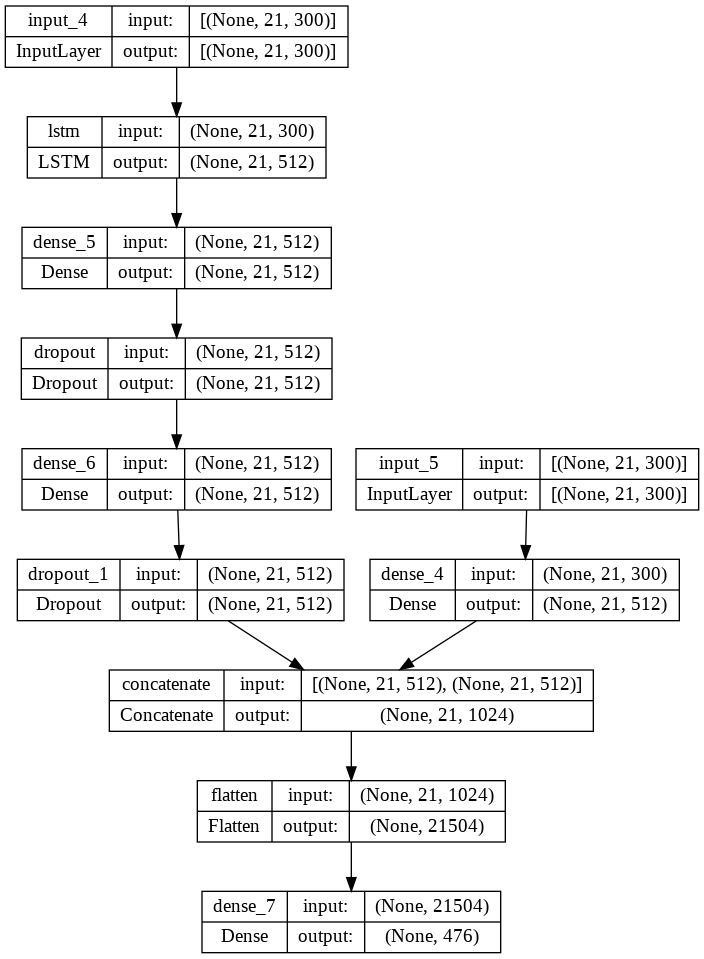

In [31]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Compiling and fitting the model

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01),loss ='sparse_categorical_crossentropy', metrics=['accuracy'])


In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 21, 300)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 21, 512)      1665024     ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 21, 512)      262656      ['lstm[0][0]']                   
                                                                                                  
 dropout (Dropout)              (None, 21, 512)      0           ['dense_5[0][0]']                
                                                                                            

In [47]:
model.fit([img, que], ans, epochs = 500, batch_size=32, verbose=1)

Epoch 1/500
32/32 [==============================] - 0s 13ms/step - loss: 2.2083 - accuracy: 0.9280
Epoch 2/500
32/32 [==============================] - 0s 11ms/step - loss: 1.6199 - accuracy: 0.9330
Epoch 3/500
32/32 [==============================] - 0s 11ms/step - loss: 1.7743 - accuracy: 0.9260
Epoch 4/500
32/32 [==============================] - 0s 11ms/step - loss: 1.7869 - accuracy: 0.9380
Epoch 5/500
32/32 [==============================] - 0s 11ms/step - loss: 1.7305 - accuracy: 0.9420
Epoch 6/500
32/32 [==============================] - 0s 11ms/step - loss: 1.2940 - accuracy: 0.9440
Epoch 7/500
32/32 [==============================] - 0s 11ms/step - loss: 1.1772 - accuracy: 0.9500
Epoch 8/500
32/32 [==============================] - 0s 11ms/step - loss: 1.2631 - accuracy: 0.9490
Epoch 9/500
32/32 [==============================] - 0s 11ms/step - loss: 1.1038 - accuracy: 0.9630
Epoch 10/500
32/32 [==============================] - 0s 11ms/step - loss: 1.1355 - accuracy: 0.9490

## Model Prediction and Analysis

In [48]:
prediction = tf.argmax(model.predict([img, que]),axis=1).numpy()

32/32 [==============================] - 0s 6ms/step


In [49]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/VQA_RAD Image Folder/'
import json
x = open('/content/drive/MyDrive/Colab Notebooks/Medical Question Answeringg/trainset.json','r')
train = json.load(x)
train[0]

{'qid': 1,
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'answer': 'Yes',
 'answer_type': 'CLOSED',
 'question_type': 'PRES',
 'question': 'Are regions of the brain infarcted?',
 'phrase_type': 'freeform'}

## Result

The Question is: What type of imaging does this not represent?
The answer is:  Actual: ultrasound Prediction: ultrasound


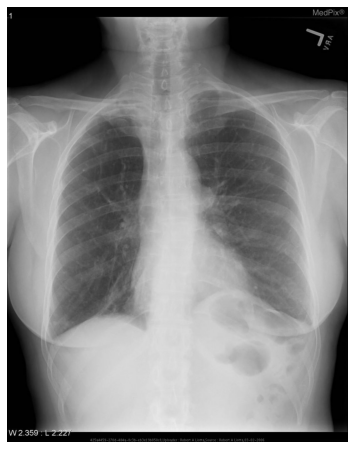

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
# for i in range(760,770,2):
plt.figure(figsize=(10,8))
image = cv2.imread(img_path+ train[3]['image_name'])
plt.imshow(image)

value = " Actual: "+str(train[3]['answer']) + " Prediction: " + itoa[prediction[3]]

plt.axis('off')
print("The Question is:",train[3]['question'])
print("The answer is:",value)
plt.show()

The Question is: Where is the abnormality?
The answer is:  Actual: left temporal lobe Prediction: left temporal lobe


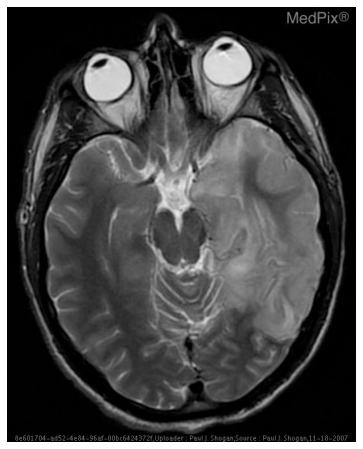

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
# for i in range(760,770,2):
plt.figure(figsize=(10,8))
image = cv2.imread(img_path+ train[8]['image_name'])
plt.imshow(image)

value = " Actual: "+str(train[8]['answer']) + " Prediction: " + itoa[prediction[8]]

plt.axis('off')
print("The Question is:",train[8]['question'])
print("The answer is:",value)
plt.show()

The Question is: Is/Are there thickening in the patient's small bowel wall?
The answer is:  Actual: Yes Prediction: yes


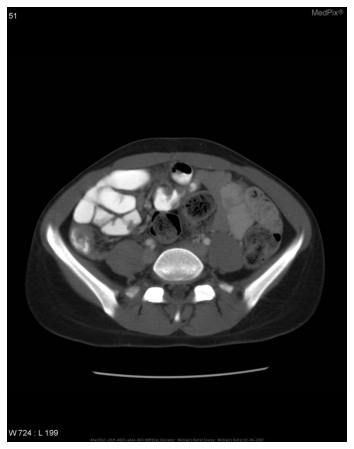

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
# for i in range(760,770,2):
plt.figure(figsize=(10,8))
image = cv2.imread(img_path+ train[33]['image_name'])
plt.imshow(image)

value = " Actual: "+str(train[33]['answer']) + " Prediction: " + itoa[prediction[33]]

plt.axis('off')
print("The Question is:",train[33]['question'])
print("The answer is:",value)
plt.show()